# CS530 Homework 6 Part1

In [26]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt


def predict_logistic_regression(descriptors, target, logit=None):
    if logit is None:
        logit = LogisticRegression(solver='lbfgs', random_state=0, max_iter=10000).fit(descriptors, target)
    logit.predict(descriptors)
    accuracy = logit.score(descriptors, target)
    print(accuracy)
    return logit


def calculate_confusion_buckets(trueValues, predictedValues):
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(len(predictedValues)):
        if trueValues[i] == predictedValues[i] == 1:
            tp += 1
        if predictedValues[i] == 1 and trueValues[i] != predictedValues[i]:
            fp += 1
        if trueValues[i] == predictedValues[i] == 0:
            tn += 1
        if predictedValues[i] == 0 and trueValues[i] != predictedValues[i]:
            fn += 1
    return tp, fp, tn, fn


def calculate_sensitivity(tp, fn):
    return tp / (tp + fn)


def calculate_specificity(tn, fp):
    return tn / (tn + fp)

#### Question 1. (4 points)

a. Files 'train.csv' and 'test.csv' contain data for the Heart Disease dataset. Use the scikit-learn package to train a logistic regression model on the training set, train.csv, and predict on the test set, test.csv. The variable that you are predicting is named 'target'. Give an accuracy of your prediction on the test set. You can find the description of the data in 'heart-disease.names' file.

In [27]:
# Your code goes here.
trainData = pd.read_csv('data\\train.csv', sep=',', index_col=0)
trainDescriptors = trainData.drop(['target'], axis=1)
trainTarget = trainData['target']

testData = pd.read_csv('data\\test.csv', sep=',', index_col=0)
testDescriptors = testData.drop(['target'], axis=1)
testTarget = testData['target']

print('Train Data')
predictedModel = predict_logistic_regression(trainDescriptors, trainTarget, None)
print('Test Data')
testModel = predict_logistic_regression(testDescriptors, testTarget, predictedModel)

predictions = predictedModel.predict_proba(testDescriptors)
falsePositiveRate, truePositiveRate, thresholds = metrics.roc_curve(testTarget, predictions[::, 1])
areaUnderCurve = metrics.auc(falsePositiveRate, truePositiveRate)

Train Data
0.8464912280701754
Test Data
0.8552631578947368


b. Use the scikit-learn package to plot an ROC curve of the predictions on the test set from 1a.

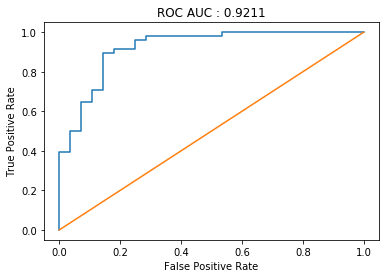

In [28]:
# Your code goes here.
givenThresholds = np.linspace(0.0, 1.0, 18)  # thresholds are arbitrary, ~18 resulted in the best AUC

plt.plot(falsePositiveRate, truePositiveRate)
plt.plot(givenThresholds, givenThresholds)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC : ' + str(np.round(areaUnderCurve, 4)))
plt.show()

c. Implement a function to plot the ROC curve of the model you get from on the test set. (Hints: 1. check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) of logistic regression to get the probability output. 2. Loop through a list of probability thresholds for classification and calculate the Specificity and Sensitivity for each threshold value.)

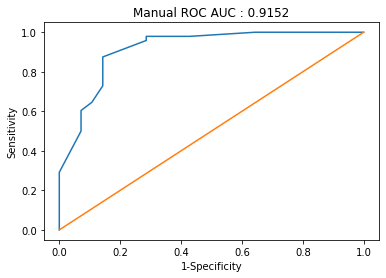

In [29]:
def roc_curve_plot(predictedProbabilities, thresholdValues, trueValues):
    rocData = pd.DataFrame({'Sensitivity': [0], '1-Specificity': [0]})
    for threshold in thresholdValues:
        predictedValue = []
        for predicted in predictedProbabilities:
            if predicted > threshold:
                predictedValue.append(1)
            else:
                predictedValue.append(0)
        trueValues = trueValues.reset_index(drop=True)
        tp, fp, tn, fn = calculate_confusion_buckets(trueValues, predictedValue)
        thresholdSensitivity = calculate_sensitivity(tp, fn)
        thresholdSpecificity = 1 - calculate_specificity(tn, fp)
        if rocData['Sensitivity'].iat[-1] == thresholdSensitivity and rocData['1-Specificity'].iat[-1] == thresholdSpecificity:
            continue
        else:
            rocRow = pd.DataFrame({'Sensitivity': [thresholdSensitivity], '1-Specificity': [thresholdSpecificity]})
            rocData = rocData.append(rocRow)

    rocData = rocData.reset_index(drop=True)
    return rocData.drop(rocData.index[0], axis=0)

rocData = roc_curve_plot(predictions[::, 1], givenThresholds, testTarget)
currentAuc = metrics.auc(rocData['1-Specificity'], rocData['Sensitivity'])

plt.plot(rocData['1-Specificity'], rocData['Sensitivity'], label='Sensitivity vs Specificity')
plt.plot(givenThresholds, givenThresholds)
plt.ylabel('Sensitivity')
plt.xlabel('1-Specificity')
plt.title('Manual ROC AUC : ' + str(np.round(currentAuc, 4)))
plt.show()

#### Question 2 (3 points)

a. Use the same dataset in Question 1 to train a classification model with the LDA algorithm. Give a prediction accuracy on the test set.

In [30]:
# Your code goes here
def predict_linear_discriminant(descriptors, target, linearDiscriminant=None):
    if linearDiscriminant is None:
        linearDiscriminant = LinearDiscriminantAnalysis().fit(descriptors, target)
    linearDiscriminant.predict(descriptors)
    accuracy = linearDiscriminant.score(descriptors, target)
    print(accuracy)
    return linearDiscriminant


print('Train Data')
predictedModel = predict_linear_discriminant(trainDescriptors, trainTarget, None)

print('Test Data')
testModel = predict_linear_discriminant(testDescriptors, testTarget, predictedModel)

predictions = predictedModel.predict_proba(testDescriptors)
falsePositiveRate, truePositiveRate, thresholds = metrics.roc_curve(testTarget, predictions[::, 1])
areaUnderCurve = metrics.auc(falsePositiveRate, truePositiveRate)

Train Data
0.8377192982456141
Test Data
0.8552631578947368


b. Plot the ROC curve of the LDA model you trained in 2a on the test set. You can use the scikit-learn package.

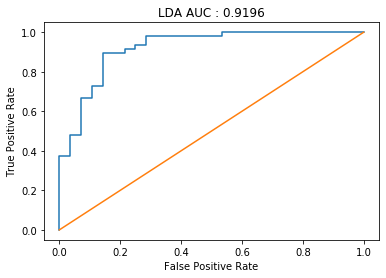

In [31]:
# Your code goes here
givenThresholds = np.linspace(0.0, 1.0, 18)  # thresholds are arbitrary, ~18 resulted in the best AUC

plt.plot(falsePositiveRate, truePositiveRate)
plt.plot(givenThresholds, givenThresholds)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LDA AUC : ' + str(np.round(areaUnderCurve, 4)))
plt.show()

c. Compare the ROC and accuracy on the test set that you get from Questions 1 and 2. Which algorithm performs better on this dataset? Explain your answer and hypothesize why one algorithm might be better than the other on this dataset.

LDA is worse than Logistic Regression in this case, but not by much. Most of the differences can be explained by the assumptions
required to make LDA work. Primarily being that LDA assumes identical covariance between descriptors and the same number of observations
between the test and training data. 

Lastly, LDA is more sensitive to outliers than Logistic Regression. As the differences in our accuracy is fairly small,
it may be safe to assume that the differences are the result of differences in covariance and number of observations between 
the test and training set.